# Learning Word Meta-Embeddings by Autoencoding

https://www.aclweb.org/anthology/C18-1140/

Danushka Bollegala, Cong Bao

In [49]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [65]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [66]:
%matplotlib inline

In [25]:
train_bertweet = np.load('../data/features/train_bertweet_embeddings.npy')
test_bertweet = np.load('../data/features/test_bertweet_embeddings.npy')
bertweet = np.vstack([train_bertweet, test_bertweet])

train_nnlm = np.load('../data/features/train_nnlm_en_128_norm_embeddings.npy')
test_nnlm = np.load('../data/features/test_nnlm_en_128_norm_embeddings.npy')
nnlm = np.vstack([train_nnlm, test_nnlm])

train_bert_sst2 = np.load('../data/features/train_bert_sst2_embeddings.npy')
test_bert_sst2 = np.load('../data/features/test_bert_sst2_embeddings.npy')
bert_sst2 = np.vstack([train_bert_sst2, test_bert_sst2])

train_use = np.load('../data/features/train_use4_embeddings.npy')
test_use  = np.load('../data/features/test_use4_embeddings.npy')
use = np.vstack([train_use, test_use])

In [27]:
embeddings = np.hstack([bertweet, nnlm, bert_sst2, use])

In [39]:
embeddings.shape

(10876, 2176)

In [43]:
X_train, X_valid = train_test_split(embeddings, test_size=0.15)
dataset_train = tf.data.Dataset.from_tensor_slices(X_train)
dataset_valid = tf.data.Dataset.from_tensor_slices(X_valid)

dataset_train = dataset_train.map(lambda x: (x,x))
dataset_train = dataset_train.shuffle(10000)
dataset_train = dataset_train.batch(512)

dataset_valid = dataset_valid.map(lambda x: (x,x))
dataset_valid = dataset_valid.shuffle(10000)
dataset_valid = dataset_valid.batch(512)


#From Aurelien Geron's Hands-on Machine Learning 2nd ed. https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense=dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros", shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [50]:
#normal accuracy stays at 0
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [77]:
keras.backend.clear_session()

dense_1 = keras.layers.Dense(3072, activation="selu")
dense_2 = keras.layers.Dense(2048, activation="selu")
dense_3 = keras.layers.Dense(1024, activation="selu")
dense_4 = keras.layers.Dense(512, activation="selu")

encoder = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=dataset_train.element_spec[0].shape[1:]),
    dense_1,
    dense_2,
    dense_3,
    dense_4
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_4, activation="selu"),
    DenseTranspose(dense_3, activation="selu"),
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid")
])
tied_ae = keras.models.Sequential([encoder, tied_decoder])

In [93]:
dataset_train.element_spec[0].shape[1:]

TensorShape([2176])

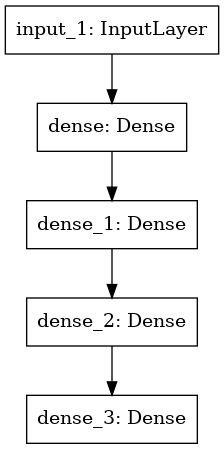

In [78]:
tf.keras.utils.plot_model(encoder)

In [79]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.001, verbose=1, factor=0.5, patience=3)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_rounded_accuracy', min_delta=0.0001, verbose=1, patience=3)

callback_list = [reduce_lr, early_stopping]

tied_ae.compile(loss="mse", optimizer=keras.optimizers.Adagrad(), metrics=[rounded_accuracy])

In [80]:
hist = tied_ae.fit(dataset_train, epochs=100, validation_data=dataset_valid, callbacks=callback_list)

Epoch 1/100
1156/1156 [==============================] - 8s 6ms/step - loss: 0.2864 - rounded_accuracy: 0.6101 - val_loss: 0.1268 - val_rounded_accuracy: 0.8288
Epoch 2/100
1156/1156 [==============================] - 7s 6ms/step - loss: 0.1160 - rounded_accuracy: 0.8362 - val_loss: 0.0999 - val_rounded_accuracy: 0.8447
Epoch 3/100
1156/1156 [==============================] - 7s 6ms/step - loss: 0.0990 - rounded_accuracy: 0.8447 - val_loss: 0.0961 - val_rounded_accuracy: 0.8450
Epoch 4/100
1156/1156 [==============================] - 7s 6ms/step - loss: 0.0957 - rounded_accuracy: 0.8454 - val_loss: 0.0943 - val_rounded_accuracy: 0.8457
Epoch 5/100
1156/1156 [==============================] - 7s 6ms/step - loss: 0.0943 - rounded_accuracy: 0.8460 - val_loss: 0.0933 - val_rounded_accuracy: 0.8466
Epoch 6/100
1156/1156 [==============================] - 7s 6ms/step - loss: 0.0933 - rounded_accuracy: 0.8469 - val_loss: 0.0924 - val_rounded_accuracy: 0.8475
Epoch 7/100
1156/1156 [===========

In [81]:
metrics = pd.DataFrame(hist.history)

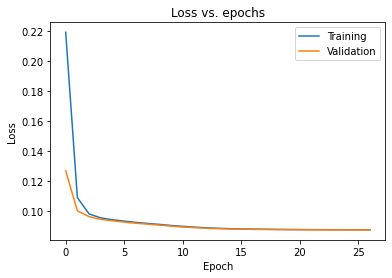

In [82]:
plt.plot(metrics['loss'])
plt.plot(metrics['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

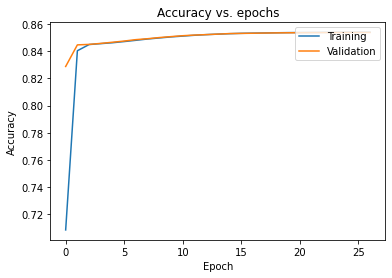

In [83]:
plt.plot(metrics['rounded_accuracy'])
plt.plot(metrics['val_rounded_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [107]:
train_to_autoencode = tf.constant(np.hstack([train_bertweet, train_nnlm, train_bert_sst2, train_use]))
test_to_autoencode = tf.constant(np.hstack([test_bertweet, test_nnlm, test_bert_sst2, test_use]))

In [108]:
train_to_autoencode

<tf.Tensor: shape=(7613, 2176), dtype=float32, numpy=
array([[ 0.20819084, -0.20918708,  0.01169901, ..., -0.03765526,
        -0.06941316, -0.08671616],
       [ 0.28813052, -0.19459179,  0.0978656 , ..., -0.00457899,
        -0.02120871,  0.00290395],
       [ 0.2714922 , -0.20920508,  0.09564154, ..., -0.05414997,
         0.07224017,  0.05789763],
       ...,
       [ 0.20964071, -0.22425564,  0.06770826, ..., -0.05840641,
        -0.01960978, -0.08983655],
       [ 0.14544944, -0.3062924 ,  0.0741189 , ..., -0.01396656,
        -0.06471784, -0.07085626],
       [ 0.29596677, -0.18777893,  0.00949495, ...,  0.00945406,
         0.02885956,  0.0456291 ]], dtype=float32)>

In [104]:
train_to_autoencode.shape

(7613, 2176)

In [113]:
train_ae_embeddings = encoder(train_to_autoencode).numpy()
test_ae_embeddings = encoder(test_to_autoencode).numpy()

In [115]:
train_ae_embeddings.shape

(7613, 512)

In [116]:
with open('../data/features/train_ae_embeddings.npy', 'wb') as f:
    np.save(f, train_ae_embeddings)
with open('../data/features/test_ae_embeddings.npy', 'wb') as f:
    np.save(f, test_ae_embeddings)